## Single Task Learning prediction for kinases with data from ChEMBL
This notebook evaluates and compares the performance of three regressors, Random Forests, Neural Networks, and Lasso Regression, all implemented by Scikit-learn for predicting bioactivity values. We are using pIC50 values on a dataset with 110 targets. As we are not interested for optimisation at this point, we run just a quick parameter selection through a 4-fold cross-validation.

## 0. Prerequisites

In [1]:
import numpy as np
import pandas as pd
import keras
import os, pickle

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
from keras.models import load_model, model_from_json
# from sklearn.decomposition import TruncatedSVD as tSVD

import  matplotlib.pyplot as plt
from time import time

random_seed = 2019
np.random.seed(random_seed)
nfolds=4
njobs =3
pathtosaved = 'ECFP/TrainedModels/'
# RESCALE_FACTOR = 10.0 # 0-10000 -> 0-1000 # no need for that, we use -logIC50 instead.

Using TensorFlow backend.


### Split to Train-Validation sets

In [2]:
if os.path.isfile("Interactions_Trainset.tab"):
    # train-valid exist so, load them
    print("Loading train/valid sets...")
    Interactions_train = []    
    with open("Interactions_Trainset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])
    
    Interactions_valid = []        
    with open("Interactions_Validset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])
else:
    # train-valid sets do not exist, so create them
    print("Creating new train/valid sets...")
    indices = list(range(len(Interactions)))
    split = int(np.floor( 0.2*( len(indices)) ))
    # split the active interactions in train-test sets
    np.random.shuffle( indices ) # this happens in-place
    
    Interactions_train = [ Interactions[x] for x in indices[split:] ] # the last 80%
    Interactions_valid = [ Interactions[x] for x in indices[:split] ] # the first 20%
    
    with open("Interactions_Trainset.tab",'w') as f:
        for line in Interactions_train:
            f.write( "{0}\t{1}\t{2:.6f}\n".format(line[0],line[1],line[2] ))
            
    with open("Interactions_Validset.tab",'w') as f:
        for line in Interactions_valid:
            f.write( "{0}\t{1}\t{2:.6f}\n".format(line[0],line[1],line[2] ))
            
Interactions = [x for x in Interactions_train]
Interactions.extend(Interactions_valid)
print("Basic stats about whole - train - validation sets:")
print( np.mean([x[2] for x in Interactions]), '\t', np.mean([x[2] for x in Interactions_valid]), '\t', np.mean([x[2] for x in Interactions_train]) )
print( np.std([x[2] for x in Interactions]) , '\t', np.std([x[2] for x in Interactions_valid]) , '\t', np.std([x[2] for x in Interactions_train])  )

Loading train/valid sets...
Basic stats about whole - train - validation sets:
4.395417284295644 	 4.402954075633978 	 4.393533169991576
2.588704763200101 	 2.5731665596073765 	 2.5925711685326958


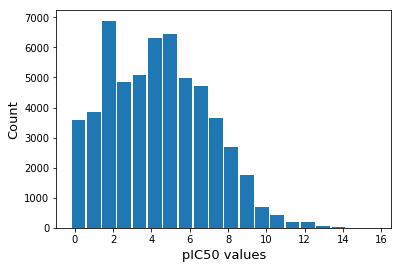

In [3]:
plt.hist([t[2] for t in Interactions], bins=20, rwidth=0.90)
plt.xlabel('pIC50 values', fontsize=13)
plt.ylabel('Count',fontsize=13)
# plt.savefig("TrueDistr.png")
plt.show()

In [4]:
# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))
del temp, DF, Interactions


There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
23167 fingerprints were loaded!


## 1. Random Forests

In [5]:
Target_info = {} # this is a "global" variable

RF_all = dict()
Scores_RF_train=[]
count=0
param_grid={'n_estimators':[10,25,50,100,150], 'max_depth':[3,4,5,7,10,15,20], 'max_features':['sqrt','auto']}
for target in Targets:
    Target_info[target] = {}
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    Target_info[target]['train_size']=len(Y_train) # add info
    if len(Y_train)>40:
        if os.path.isfile(pathtosaved+'RF_'+target+'_'+'pIC50new.sav'):
            # model is already trained - just load
            with open( pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'rb') as f:
                RFR = pickle.load( f )
        else:
            print("training...")
            # we need to ensure there is enough data for CV
            cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
            # here comes the long step
            cvr.fit(X_train, Y_train)
            # select best parametrisation and train to the complete train-set
            RFR = RandomForestRegressor( n_estimators= cvr.best_params_['n_estimators'],max_features=cvr.best_params_['max_features'], max_depth=cvr.best_params_['max_depth'], random_state=2019)
            RFR.fit(X_train,Y_train)
            # save model
            pickle.dump(RFR, open(pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'wb'))
        RF_all[target] = RFR
        Scores_RF_train.append( RFR.score( X_train,  Y_train))
        Target_info[target]['RF_train_r2'] = Scores_RF_train[-1] # add info
#         print(Scores_RFR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_RF_train))
    count+=1
    
print("Mean score for RF during training = %f" % np.mean(Scores_RF_train) )

More than 0 targets are processed
Mean score so far: 0.831654
More than 25 targets are processed
Mean score so far: 0.902368
More than 50 targets are processed
Mean score so far: 0.906152
More than 75 targets are processed
Mean score so far: 0.907381
More than 100 targets are processed
Mean score so far: 0.899331
Mean score for RF during training = 0.897586


## 2. Neural Networks

In [6]:
NN_all = dict()
Scores_NN_train=[]
param_grid={'hidden_layer_sizes':[(50),(100,20),(100,50),(500,20,10)] }
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if os.path.isfile(pathtosaved+'NN_'+target+'_'+'pIC50new.sav'):
        # model is already trained - just load
        with open( pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
            MLPR = pickle.load( f )
    else:
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(MLPRegressor(activation='tanh', solver='lbfgs', random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        MLPR = MLPRegressor( hidden_layer_sizes = cvr.best_params_['hidden_layer_sizes'], activation='tanh', solver='lbfgs', random_state=2019)
        MLPR.fit(X_train,Y_train)
        pickle.dump(MLPR, open(pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'wb'))
    NN_all[target] = MLPR
    Scores_NN_train.append( MLPR.score( X_train,  Y_train))
    Target_info[target]['NN_train_r2'] = Scores_NN_train[-1] # add info
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_NN_train))
    count+=1
    
print("Mean score for NN during training = %f" % np.mean(Scores_NN_train))

More than 0 targets are processed
Mean score so far: 1.000000
More than 25 targets are processed
Mean score so far: 0.995388
More than 50 targets are processed
Mean score so far: 0.995728
More than 75 targets are processed
Mean score so far: 0.995610
More than 100 targets are processed
Mean score so far: 0.993780
Mean score for NN during training = 0.992995


## 3. Lasso Regression

In [7]:
from sklearn.linear_model import Lasso

LR_all = dict()
Scores_LR_train=[]
param_grid={'alpha':[1, 0.5, 0.1, 0.01]}
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    
    if os.path.isfile(pathtosaved+'LR_'+target+'_'+'pIC50new.sav'):
        # model is already trained - just load
        with open( pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
            LR = pickle.load( f )
    else:
        print("cross validation")
        cvr = GridSearchCV(Lasso(random_state=2019, max_iter=3000), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation
        LR = Lasso( alpha= cvr.best_params_['alpha'], max_iter=3000, random_state=2019)
        LR.fit(X_train,Y_train)
        pickle.dump(LR, open(pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'wb'))
        
    Scores_LR_train.append( LR.score( X_train,  Y_train))
    Target_info[target]['LR_train_r2'] = Scores_LR_train[-1] # add info
    LR_all[target] = LR
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_LR_train))
    count+=1 

print("Mean score for LR during training = %f" % np.mean(Scores_LR_train) )

More than 0 targets are processed
Mean score so far: 0.635197
More than 25 targets are processed
Mean score so far: 0.782202
More than 50 targets are processed
Mean score so far: 0.785533
More than 75 targets are processed
Mean score so far: 0.778149
More than 100 targets are processed
Mean score so far: 0.760982
Mean score for LR during training = 0.752432


## 4. Personalised NN with Keras

In [34]:
myNN_all = dict()
Scores_myNN_train=[]
param_grid={'lamda':[0.2, 0.1, 0.01, 0.001]}
count=0

def mymodel(lamda, init=4.5):
    model = Sequential()

    model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=2048))
    model.add(Dense(units=20,  activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=100 ))
    myinit = keras.initializers.Constant(value=init)
    model.add(Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.001)))
    
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.001))
    return model

for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
        
    X_train = np.array( X_train )

    if os.path.isfile(pathtosaved+'Keras/Keras_'+target+'_'+'pIC50model.json'):
        # model is already trained for current target
        with open( pathtosaved+'Keras/Keras_'+target+'_'+'pIC50model.json', 'r') as jsonf:
            json_model = jsonf.read()
        myNN = model_from_json(json_model)
        myNN.load_weights( pathtosaved+'Keras/Keras_'+target+'_'+'weights.h5'  )
        myNN.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.001))
#         myNN.fit(X_train,Y_train, epochs=250, batch_size=20, verbose=0)
    else:
        print("training for", target)
        myNN = KerasRegressor(build_fn=mymodel, init=4.5, epochs=250, batch_size=20, verbose=0)
        # fit model to data:
        cvr = GridSearchCV(myNN, param_grid=param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        myNN = KerasRegressor(build_fn=mymodel, init=4.5, lamda=cvr.best_params_['lamda'], epochs=250, batch_size=20, verbose=0)
        myNN.fit(X_train,Y_train)
        # save:
        model_json=myNN.model.to_json()
        with open( pathtosaved+'Keras/Keras_'+target+'_'+'pIC50model.json', 'w') as jsonf:
            jsonf.write(model_json)
        myNN.model.save_weights( pathtosaved+'/Keras/Keras_'+target+'_'+'weights.h5' )
    Y_NN = myNN.predict(X_train)
    # get scores and details:
    Scores_myNN_train.append( r2_score(Y_train, Y_NN) )
    Target_info[target]['my_train_r2'] = Scores_myNN_train[-1] # add info
    myNN_all[target] = myNN # save model for validation
    if count%20==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_myNN_train))
    count+=1
    
print("Mean score for myNN during training = %f" % np.mean(Scores_myNN_train) )

More than 0 targets are processed
Mean score so far: 0.996832
More than 20 targets are processed
Mean score so far: 0.964179
More than 40 targets are processed
Mean score so far: 0.977388
More than 60 targets are processed
Mean score so far: 0.977925
More than 80 targets are processed
Mean score so far: 0.974870
More than 100 targets are processed
Mean score so far: 0.971857
Mean score for myNN during training = 0.971425


## 5. Evaluation

In [35]:
Pred_NN = []; Pred_RF  = []; Pred_LR = []; Pred_my=[];
True_vals = []
Pred_pertarget = dict() # contains lists with tuples: (true, pred_RF, pred_NN)

Time_RF=0; Time_NN=0; Time_LR=0; Time_my=0
with open("SingleTL_final_results.txt",'w') as f:
#     this file contains all the important stuff for the comparison
    f.write("Target\tCompound\tTrue\tRFR\tMLPR\tLR\tKeras\n")
    for point in Interactions_valid:
        # point = [ target, compound, pIC50 ]
        True_vals.append( float(point[2]) )
        x_test = np.array( Fingerprints[point[1]] ).reshape(1,-1) # prepare for prediction
        
        t0=time()
        model = RF_all[point[0]]
        Pred_RF.append( model.predict( x_test ) )
        Time_RF+=time()-t0
        
        t0=time()
        model = NN_all[point[0]]
        Pred_NN.append( model.predict( x_test ) )
        Time_NN+=time()-t0
        
        t0=time()
        model = LR_all[point[0]]
        Pred_LR.append( model.predict( x_test ) )
        Time_LR+=time()-t0
        
        t0=time()
        model = myNN_all[point[0]]
        Pred_my.append( model.predict( x_test )[0] )
        Time_my+=time()-t0
        
        f.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(point[0], point[1], point[2], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]))

        if point[0] in Pred_pertarget:
            Pred_pertarget[point[0]].append( (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0])  )
        else:
            # first time for this protein
            Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]) ]
        
print("Performance for RF = %f" % r2_score( True_vals, Pred_RF ))
print("Performance for NN = %f" % r2_score( True_vals, Pred_NN ))
print("Performance for LR = %f" % r2_score( True_vals, Pred_LR ))
print("Performance for Keras = %f" % r2_score( True_vals, Pred_my ))

Performance for RF = 0.647436
Performance for NN = 0.578135
Performance for LR = 0.591053
Performance for Keras = 0.608141


In [36]:
print("RF: Duration per 1000 predictions = {0}".format(1000*Time_RF/len(Interactions_valid) ))
print("LR: Duration per 1000 predictions = {0}".format(1000*Time_LR/len(Interactions_valid) ))
print("NN: Duration per 1000 predictions = {0}".format(1000*Time_NN/len(Interactions_valid) ))
print("my: Duration per 1000 predictions = {0}".format(1000*Time_my/len(Interactions_valid) ))

RF: Duration per 1000 predictions = 7.4163006433972996
LR: Duration per 1000 predictions = 0.09574913813683512
NN: Duration per 1000 predictions = 0.30849941403841713
my: Duration per 1000 predictions = 4.629242650624136


In [37]:
trf = 1000*Time_RF/len(Interactions_valid); tlr = 1000*Time_LR/len(Interactions_valid)
tnn = 1000*Time_NN/len(Interactions_valid); tmy = 1000*Time_my/len(Interactions_valid)
tmt = 0.3734; tdr = 1.2
print("RF: Duration per 1000 predictions = {0}".format( trf/tmt ))
print("LR: Duration per 1000 predictions = {0}".format( tlr/tmt ))
print("NN: Duration per 1000 predictions = {0}".format( tnn/tmt ))
print("my: Duration per 1000 predictions = {0}".format( tmy/tmt ))

RF: Duration per 1000 predictions = 19.861544304759775
LR: Duration per 1000 predictions = 0.25642511552446473
NN: Duration per 1000 predictions = 0.826190182213222
my: Duration per 1000 predictions = 12.397543252876638


In [38]:
Scores_RF_valid_pertarget = []
Scores_NN_valid_pertarget = []
Scores_LR_valid_pertarget = []
Scores_my_valid_pertarget = []

for target in Pred_pertarget:
    true=[]
    pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my =[] # temp variables
    # aggregate predictions
    for point in Pred_pertarget[target]:
        true.append( point[0] )
        pred_RF.append( point[1] )
        pred_NN.append( point[2] )
        pred_LR.append( point[3] )
        pred_my.append( point[4] )
    Target_info[target]['test_size']=len(true) # add info
    
    # calculate performance for each method
    r2 = r2_score(true, pred_RF)
    Target_info[target]['RF_valid_r2'] = r2 # add info
    Scores_RF_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_NN)
    Target_info[target]['NN_valid_r2'] = r2 # add info
    Scores_NN_valid_pertarget.append( r2 )

    r2 = r2_score(true, pred_LR)
    Target_info[target]['LR_valid_r2'] = r2 # add info
    Scores_LR_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_my)
    Target_info[target]['my_valid_r2'] = r2 # add info
    Scores_my_valid_pertarget.append( r2 )

    print("R2 score for {0}, RF | NN | LR | Keras = {1:.2f} | {2:.2f} | {3:.2f} | {4:.3f}".format(target, Scores_RF_valid_pertarget[-1], Scores_NN_valid_pertarget[-1], Scores_LR_valid_pertarget[-1], Scores_my_valid_pertarget[-1]))

R2 score for CHEMBL260, RF | NN | LR | Keras = 0.59 | 0.34 | 0.50 | 0.549
R2 score for CHEMBL4722, RF | NN | LR | Keras = 0.67 | 0.53 | 0.59 | 0.602
R2 score for CHEMBL2695, RF | NN | LR | Keras = 0.71 | 0.65 | 0.68 | 0.626
R2 score for CHEMBL3038477, RF | NN | LR | Keras = 0.43 | 0.24 | 0.42 | 0.297
R2 score for CHEMBL2996, RF | NN | LR | Keras = 0.51 | 0.44 | 0.46 | 0.561
R2 score for CHEMBL2148, RF | NN | LR | Keras = 0.75 | 0.72 | 0.71 | 0.719
R2 score for CHEMBL2147, RF | NN | LR | Keras = 0.66 | 0.64 | 0.66 | 0.663
R2 score for CHEMBL5147, RF | NN | LR | Keras = 0.41 | 0.06 | 0.35 | 0.306
R2 score for CHEMBL308, RF | NN | LR | Keras = 0.51 | 0.49 | 0.53 | 0.547
R2 score for CHEMBL3234, RF | NN | LR | Keras = 0.53 | 0.46 | 0.32 | 0.488
R2 score for CHEMBL4523, RF | NN | LR | Keras = 0.61 | 0.58 | 0.59 | 0.578
R2 score for CHEMBL2358, RF | NN | LR | Keras = 0.31 | -0.13 | 0.26 | 0.097
R2 score for CHEMBL1936, RF | NN | LR | Keras = 0.40 | 0.42 | 0.33 | 0.412
R2 score for CHEMBL3629

In [23]:
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_valid_pertarget), np.std(Scores_RF_valid_pertarget) )) 
print("Mean per target R2-score for NN = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_NN_valid_pertarget), np.std(Scores_NN_valid_pertarget) ))
print("Mean per target R2-score for LR = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_LR_valid_pertarget), np.std(Scores_LR_valid_pertarget) ))
print("Mean per target R2-score for my = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_my_valid_pertarget), np.std(Scores_my_valid_pertarget) ))

Mean per target R2-score for RF = 0.5014 and std = 0.1661
Mean per target R2-score for NN = 0.3982 and std = 0.2390
Mean per target R2-score for LR = 0.4190 and std = 0.2135
Mean per target R2-score for my = 0.3705 and std = 0.4449


## 6. Analysis and Plotting

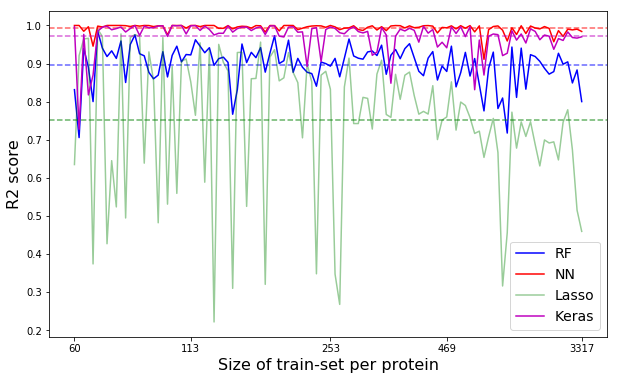

In [39]:
plt.figure(figsize=(10,6))

Y = [Target_info[x]['RF_train_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_train_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_train_r2'] for x in Targets]
plt.plot(Y,'g', label='Lasso', alpha=0.4)
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_train_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

Sizes = [Target_info[x]['train_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Size of train-set per protein',fontsize=16)
plt.ylabel("Accuracy in R2",fontsize=16)
# plt.xticks( x, rotation='vertical')
plt.legend(loc=4, fontsize=14)
# plt.title("Training Performance")
plt.savefig("Train-all.png", transparent=True)
plt.show()

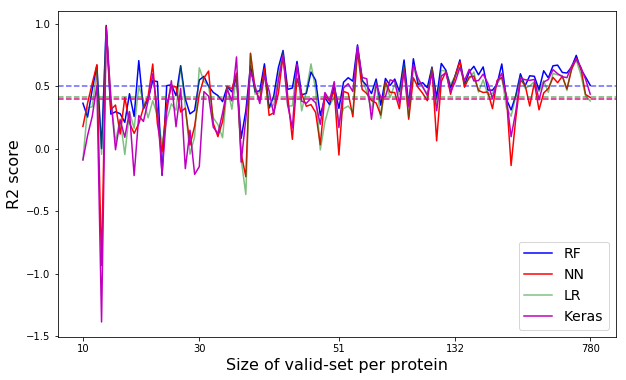

In [40]:
plt.figure(figsize=(10,6))

Y = [Target_info[x]['RF_valid_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_valid_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_valid_r2'] for x in Targets]
plt.plot(Y,'g', alpha=0.5, label='LR')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_valid_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

plt.legend(loc=4, fontsize=14)
Sizes = [Target_info[x]['test_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Size of valid-set per protein',fontsize=16)
plt.ylabel("Accuracy in R2",fontsize=16)
# plt.title("Validation Performance")
plt.savefig("Valid-all.png", transparent=True)
plt.show()

### Just a scatterplot for all three approaches

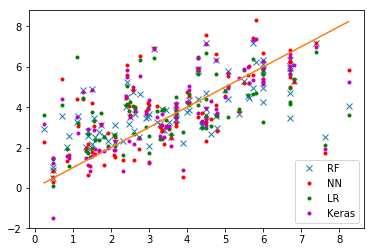

In [26]:
target = Targets[70]
true=[]
pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my=[];
# aggregate predictions
for tuples in Pred_pertarget[target]:
    true.append( tuples[0] )
    pred_RF.append( tuples[1] )
    pred_NN.append( tuples[2] )
    pred_LR.append( tuples[3] )
    pred_my.append( tuples[4] )
    
plt.figure()
plt.plot(true, pred_RF,'x',label='RF')
plt.plot(true, pred_NN,'r.',label='NN')
plt.plot(true, pred_LR,'g.',label='LR')
plt.plot(true, pred_my,'m.',label='Keras')
plt.plot([min(true), max(true)], [min(true), max(true)])
plt.legend(loc=4)
plt.show()

### How to get the dominant parametrisations

In [44]:
from scipy.stats import mode
temp1 = []; temp2=[]; temp3=[]; temp4=[]; temp5=[];
for model in LR_all:
    temp1.append( LR_all[model].get_params()['alpha'] )
    temp2.append( RF_all[model].get_params()['n_estimators'] )
    temp3.append( RF_all[model].get_params()['max_depth'] )
    temp4.append( NN_all[model].get_params()['hidden_layer_sizes'])
#     temp5.append( myNN_all[model].get_params()['lamda'] )
print('LR - best alpha = {0} with {1}.'.format( mode(temp1)[0], mode(temp1)[1][0]) )
print('RF - best n-estimat = {0} with {1}.'.format( mode(temp2)[0], mode(temp2)[1][0]) )
print('RF - best max-depth = {0} with {1}.'.format( mode(temp3)[0], mode(temp3)[1][0]) )
# print('Keras - best lamda = {0} with {1}'.format( mode(temp5)[0], mode(temp5)[1][0]) )
temp_dict={}
for x in temp4:
    if str(x) in temp_dict:
        temp_dict[ str(x) ]+=1
    else:
        temp_dict[ str(x) ] = 1
print("NN - hidden layers:")
print( temp_dict)
# for model in NN_all:
#     print( NN_all[model].get_params()['hidden_layer_sizes'])

LR - best alpha = [0.01] with 91.
RF - best n-estimat = [150] with 48.
RF - best max-depth = [20] with 75.
NN - hidden layers:
{'(50, 20)': 43, '(50, 20, 10)': 46, '50': 16, '(50, 100)': 5}


### Cool info about coefficients by Lasso

In [27]:
# Coefficients by Lasso
Coef_LR = np.zeros(2048)
for model in LR_all:
    Coef_LR += LR_all[model].coef_
Coef_LR = Coef_LR/110  

indices_LR = []
ind = np.argsort(Coef_LR)
[indices_LR.append(x) for x in ind[:10] ]
[indices_LR.append(x) for x in ind[-10:] ]
print(indices_LR)

# Coefficients by RF
Coef_RF = np.zeros(2048)
for target in Targets:
    Coef_RF += RF_all[target].feature_importances_
Coef_RF = Coef_RF/110  

indices_RF = []
ind = np.argsort(Coef_RF)
[indices_RF.append(x) for x in ind[-20:] ]
print(indices_RF)
print("Common features:",'\t',[x for x in indices_LR if x in indices_RF])
# plt.plot( range(2048), Coef, '.')
# plt.plot( indices, Coef[indices], 'rx')
# # plt.plot( Coef[indices], 'o')
# plt.xlabel("Fingerprint Bit location",fontsize=13)
# plt.ylabel("Average Coefficient",fontsize=13)
# # plt.title("Most important FP bits")
# plt.savefig("Lasso-bits_FCFP.png")
# plt.show()

[489, 1199, 666, 1750, 1858, 1416, 1160, 202, 311, 1453, 1019, 167, 1114, 745, 352, 491, 1607, 1171, 1152, 1747]
[1199, 1586, 1019, 1452, 1171, 1160, 1114, 1367, 1617, 1088, 708, 1152, 695, 191, 8, 926, 486, 1224, 491, 935]
Common features: 	 [1199, 1160, 1019, 1114, 491, 1171, 1152]


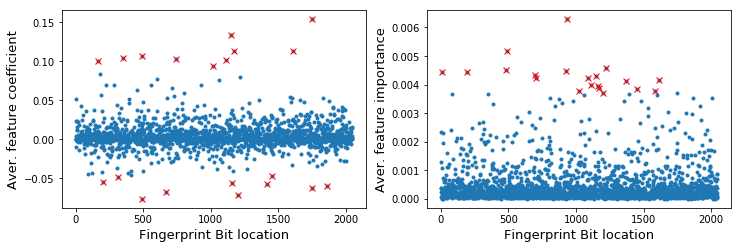

In [28]:
# fig = plt.subplots(1,2, figsize=(12,4))  # 1 row, 2 columns
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
plt.plot( range(2048), Coef_LR, '.')
plt.plot( indices_LR, Coef_LR[indices_LR], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature coefficient",fontsize=13)

ax1 = fig.add_subplot(222)
plt.plot( range(2048), Coef_RF, '.')
plt.plot( indices_RF, Coef_RF[indices_RF], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature importance",fontsize=13)
# plt.savefig("Lasso-bits_FCFP.png")
plt.show()

In [41]:
print("RMSE for RF = %f" % np.sqrt( MSE(True_vals, Pred_RF) ))
print("RMSE for NN = %f" % np.sqrt( MSE(True_vals, Pred_NN) ))
print("RMSE for LR = %f" % np.sqrt( MSE(True_vals, Pred_LR) ))
print("RMSE for Keras = %f" % np.sqrt( MSE(True_vals, Pred_my) ))

print(" MSE for RF = %f" % MSE(True_vals, Pred_RF) )
print(" MSE for NN = %f" % MSE(True_vals, Pred_NN) )
print(" MSE for LR = %f" % MSE(True_vals, Pred_LR) )
print(" MSE for Keras = %f" %MSE(True_vals, Pred_my))

RMSE for RF = 1.527872
RMSE for NN = 1.671301
RMSE for LR = 1.645514
RMSE for Keras = 1.610766
 MSE for RF = 2.334393
 MSE for NN = 2.793246
 MSE for LR = 2.707715
 MSE for Keras = 2.594569


### Some comparisons of distributions

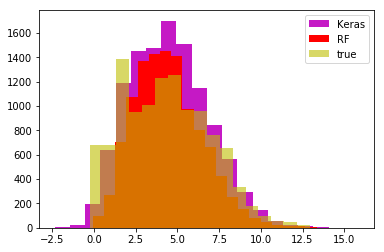

In [42]:
# plt.figure()
plt.hist([t[0] for t in Pred_my],bins=20,color='m',alpha=0.9, label="Keras")

plt.hist([t[0] for t in Pred_RF],bins=20,color='r',label="RF")

plt.hist([t for t in True_vals],bins=20,color='y',alpha=0.6, label='true')
plt.legend(loc=1)
plt.show()

### LOAD:

In [ ]:
# wheretosave='ECFP/TrainedModels/'

# for target in Targets:
#     with open( wheretosave+'RF_'+target+'_'+'pIC50model.sav', 'rb') as f:
#         RF_all[target] = pickle.load( f )
    
#     with open( wheretosave+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         LR_all[target] = pickle.load( f )
    
#     with open( wheretosave+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         NN_all[target] = pickle.load( f )

## Appendix - Old pieces of code

print("Stds per method for training:")
print(np.std(Scores_RF_train))
print(np.std(Scores_NN_train))
print(np.std(Scores_LR_train))

print("Stds per method for testing :")
print(np.std(Scores_RF_valid_pertarget))
print(np.std(Scores_NN_valid_pertarget))
print(np.std(Scores_LR_valid_pertarget))

Scores_LR_valid = []
Scores_RFR_valid = []
Scores_MLPR_valid= []
for i in range(len(Interactions_valid)):
    Scores_LR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_LR[i][0])/float(Interactions_valid[i][2]) )
    Scores_RFR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_RFR[i][0])/float(Interactions_valid[i][2]) )
    Scores_MLPR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_MLPR[i][0])/float(Interactions_valid[i][2]) )

plt.figure(figsize=(15,5))
plt.plot(Scores_LR_valid,'g', label='LR')
plt.plot(Scores_RFR_valid,'b', label='RF')
plt.plot(Scores_MLPR_valid,'r', label='NN')
plt.legend(loc=1)
plt.xlabel('Protein sets')
plt.ylabel('Residuals')
plt.title("MAE on validation set")
plt.show()

for i in range(50):
    print(True_vals[i],'\t', Pred_LR[i])
print(     MSE( True_vals, Pred_LR ))
print(r2_score( True_vals, Pred_LR ))
print(     MAE( True_vals, Pred_LR ))